#Import Packages

In [ ]:
!pip install tsfresh

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.stats import shapiro
import seaborn as sns
from random import sample

import tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, mutual_info_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

import itertools

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Import and Pre-process Data
Skip this section if feature data is already provided.

In [ ]:
def import_and_clean_data(file):
    '''
    function imports csv file of raw IMU data, then cleans and downsamples for
    use by tsfresh package.

    input: str of pathway to csv file for individual activity

    output: reformatted data frame suitable for tsfresh.extract_features()
    '''

    data = pd.read_csv(file, header = 4)

    # drop extraneous features
    data = data.iloc[:, :87]

    # keep only time points where the sync signal is on.
    data = data[data['Noraxon Desk Receiver.Sync,On'] == 1]

    # drop remaining extraneous features
    data = data.drop(["Noraxon Desk Receiver.EMG 1,uV", "Noraxon Desk Receiver.Sync,On"], axis = 1)

    # duplicate time column for tsfresh use later
    data['time'] = data['Time,s']

    # convert 'Time,s' to pandas DateTime format for decimation
    data['Time,s'] = pd.to_timedelta(data['Time,s'], unit='s')
    data.set_index('Time,s', inplace = True)

    # reduce dataset from 1500 Hz to 100 Hz and average windows
    data = data.resample('0.01S').mean()

    data['id'] = file.split('.')[0]

    return data

In [ ]:
start = time()

# collect all file names from directory in list
file_list = [i for i in os.listdir() if '.csv' in i]

# initialize dataframe for storing all time series features
features = pd.DataFrame()

# initialize list to store labels and list of known labels
label_list = ['walk', 'run', 'crawl', 'wall', 'drag', 'rush', 'stairs', 'stepover', 'window', 'static']

# start file counter
i = 0

# loop through each file to extract features
for file in file_list:

    # import and clean data
    data = import_and_clean_data(file)

    print("Extracting", file)
    # use tsfresh to extract time series features using minimal set parameters
    trial_features = extract_features(data, column_id = 'id', column_sort = 'time', default_fc_parameters = MinimalFCParameters())

    # pull true label from file name and add to pandas series of data
    trial_label = [i for i in label_list if i in file]
    trial_features["Activity"] = trial_label

    # append to current iteration of trial features
    features = pd.concat([features, trial_features])

    i += 1

# save features dataframe
features.to_csv('TimeSeriesFeatureData.csv')

# End code Here

end = time()
print('Total execution time:', str(round(end-start, 4))+'sec', 'for ', i, 'files.')

#EDA

In [ ]:
# Input path to FullFeatureDataset.csv file
path =
data = pd.read_csv(path)

print("Number of samples: ", len(data))
print("Number of NaNs: ", (data.isna().sum(axis=1) > 0).sum())
print("Number of features: ", data.shape[1] - 2)

print("Dropping 'Length' features.")
data.drop(list(data.filter(regex = 'length')), axis = 1, inplace = True)
print("New number of features: ", data.shape[1] - 2)

# delete any row (trial) that has a missing value anywhere in the features.
print("Dropping rows that contain NaN value.")
data = data.dropna()

# initialize list to store labels and list of known labels
label_list = ['walk', 'run', 'crawl', 'wall', 'drag', 'rush', 'stairs', 'stepover', 'window', 'static']

##Class Distribution

In [ ]:
# plot class distribution
sns.displot(data, x = "Activity", shrink = 0.8, height = 5, aspect = 9 / 5) # need Stratified K-fold CV
plt.title("Distribution of Activities")

##Bivariate Relationships

In [ ]:
# choose features to visualize univariate distributions
subset_names = ['Ankle Abduction LT,deg__maximum',  'Forearm roll RT,deg__standard_deviation', 'Upper arm course RT,deg__median']
# subet from dataframe
subset_features = data[subset_names]
# rename for cleaner fit
subset_features = subset_features.rename(columns = {subset_names[0]:"Ankle Abduction Max",
                                                    subset_names[1]:"Forearm Roll STD",
                                                    subset_names[2]:"Arm Course Median"})

# 2D visalization of random features
# function to hide upper triangle plots of Seaborn PairGrid
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

# plot subset of features extracted in previous cell
g = sns.PairGrid(data = subset_features)
g.map_upper(hide_current_axis)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.fig.suptitle("Univariate Distributions and Bivariate Relationships\nfor Select Time Series Features")

In [ ]:
# visualize distribution of Pearson's R Correlation Coefficients between all features
corr = np.triu(data.corr()).flatten()
corr = corr[ (corr != 0) & (corr != 1) ]

fig = plt.figure(figsize=(10, 7))
sns.histplot(corr)
plt.xlabel("r Correlation Coefficient")
plt.title("Distribution of Pearson's r Coefficients\nbetween Time Series Features")

##Univariate Distributions

In [ ]:
# plot sampled features individually as univariate distributions
fig, axes = plt.subplots(5, 1, figsize=(12, 10))
fig.tight_layout()
fig.suptitle('Sample Univariate Distributions between Activities')

for name, ax in zip(subset_features, axes.flatten()):
    sns.kdeplot(ax = ax, data = data, x = name, hue = "Activity", legend = False)

In [ ]:
# Perform test for normality on all features.
pvalues = np.empty(0)
for i in data.columns[1:-1]:
    pvalues = np.append(pvalues, shapiro(data[i])[1])

print("There are", pvalues[(pvalues > 0.05) & (pvalues < 1)].size, "features which meet normality criteria p > 0.05.")

There are 0 features which meet normality criteria p > 0.05.


## Mutual Information

In [ ]:
# calculate Mutual Information Score between all Features and the Activity Label
mis = mutual_info_classif(data.drop(["Trial", "Activity"], axis = 1, inplace = False), data["Activity"])
mis = pd.Series(mis, name = "MI Scores", index = data.drop(["Trial", "Activity"], axis = 1, inplace = False).columns).sort_values(ascending=False)

# plot sorted scores in bar graph
plt.figure(figsize=(10,6))
mis.plot(kind = 'bar')
plt.xlabel("Feature")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Score between Feature and Activity")
plt.xticks([])

In [ ]:
# call out top 8 bar plot
plt.figure(figsize=(8,5))
mis[:8].plot(kind = 'bar')
plt.ylabel("Mutual Information Score")
plt.title("Top 8 Features for Mutual Information")

##Dimensionality by PCA

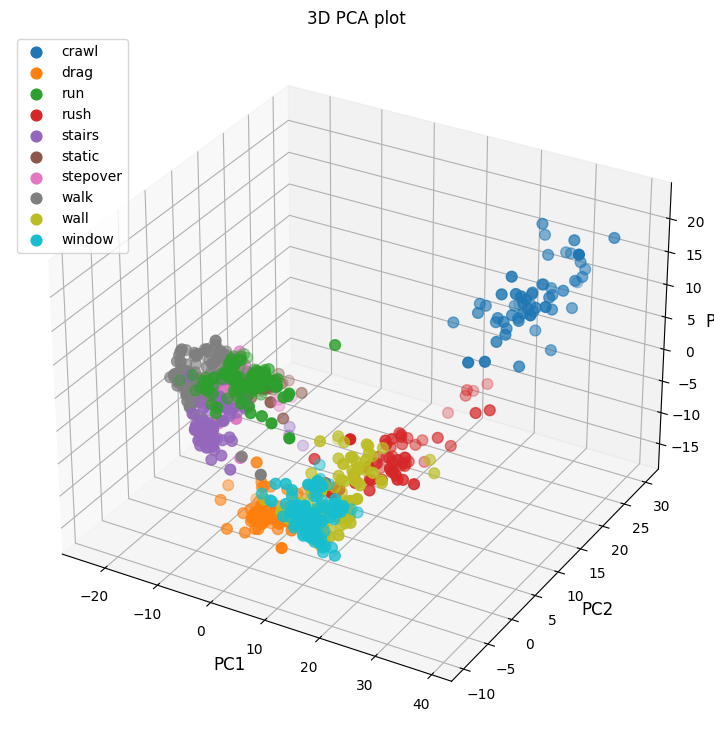

In [ ]:
# separate features from labels
X = data.drop(['Trial', 'Activity'], axis = 1)
y = data['Activity']

x_pca = StandardScaler().fit_transform(X)
x_pca = PCA(n_components = 3).fit_transform(x_pca)

# plot data components
Xax = x_pca[:,0]
Yax = x_pca[:,1]
Zax = x_pca[:,2]

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')

for l in np.unique(y):
    ix=np.where(y==l)
    ax.scatter(Xax[ix],
               Yax[ix],
               Zax[ix],
               s=60,
               label = l)

ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)

ax.legend()
plt.title("3D PCA plot")
plt.show()

# Feature Down Select

In [ ]:
# separate features from labels
X = data.drop(['Trial', 'Activity'], axis = 1)
y = data['Activity']

# test train split
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [ ]:
# Feature Selection by RFC
rfc_selection = SelectFromModel(RandomForestClassifier(n_estimators = 100))
rfc_selection.fit(X_train, y_train)

rfc_feature_names = X_train.columns[rfc_selection.get_support()]
print(len(rfc_feature_names), "features kept from Random Forest down selection.")
print("Feature Importance Threshold: ", rfc_selection.threshold_)

# transform training data into reduced features set
rfc_X_train = rfc_selection.transform(X_train)

In [ ]:
# transform feature importances into Data Frame and plot top 10 features with threshold
rfc_feature_data = pd.DataFrame({"Feature":rfc_feature_names,
                                "Importance": rfc_selection.estimator_.feature_importances_[rfc_selection.get_support()]}).sort_values(by = ['Importance'], ascending = False)

fig = plt.figure(figsize=(15, 5))
sns.barplot(data = rfc_feature_data.iloc[:10,], x = "Feature", y = "Importance")
plt.xticks(rotation = 45, ha = "right")
plt.axhline(0.001, color = 'red', linestyle = '--', label = "Inclusion Threshold")
plt.title("Top 10 Features for HAR by Random Forest Feature Importance")
plt.annotate("* Feature Importance determined by average decrease in Gini Impurity.", (5, 0.013))
plt.legend()

In [ ]:
# Dimensionality Reduction by PCA
scaled_features = StandardScaler(with_mean = True, with_std = True).fit_transform(X_train)
pca_model = PCA(n_components = 100).fit(scaled_features)

plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.title("PCA for Dimensionality Reduction")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.axvline(54, linestyle = "--", color = 'red')
plt.axhline(0.9, linestyle = '--', color = 'red')
plt.annotate("Top 54 Components Kept\nfor 90% Explained Variance", (57, 0.7))

In [ ]:
# transform X data with PCA = 54
scaled_features = StandardScaler(with_mean = True, with_std = True).fit_transform(X_train)
pca_X_train = PCA(n_components = 54).fit_transform(scaled_features)

# Train Classifiers

## RFC

In [ ]:
# initialize grid search parameters
rfc_param_grid = param_grid = {"n_estimators": [100, 200, 300],
                           "max_features": ['auto', 'sqrt', 'log2'],
                           "max_depth" : [6, 8, 10, 12],
                           "criterion" :['gini', 'entropy']}

rfc_grid_search = GridSearchCV(RandomForestClassifier(),
                               param_grid = rfc_param_grid,
                               refit = True,
                               cv = 5,
                               verbose = 2,
                               return_train_score = True)

### Full

In [ ]:
# train full feature rfc model
rfc_full_feature_model = rfc_grid_search.fit(X_train, y_train)

###PCA

In [ ]:
rfc_pca_feature_model = rfc_grid_search.fit(pca_X_train, y_train)

## GBC

In [ ]:
# initialize grid search parameters
gbc_param_grid = {"learning_rate": [0.01, 0.025, 0.05],
                  "max_depth": [8, 10, 12],
                  "n_estimators": [100, 200]}

gbc_grid_search = GridSearchCV(GradientBoostingClassifier(),
                               param_grid = gbc_param_grid,
                               refit = True,
                               cv = 5,
                               verbose = 2,
                               return_train_score = True)


### Full

In [ ]:
gbc_full_feature_model = gbc_grid_search.fit(X_train, y_train)

### PCA

In [ ]:
gbc_pca_feature_model = gbc_grid_search.fit(pca_X_train, y_train)

### RFC

In [ ]:
gbc_rfc_feature_model = gbc_grid_search.fit(rfc_X_train, y_train)

## SVM

In [ ]:
# initialize grid search parameters
svm_param_grid = {"C": [0.1, 1, 10, 100],
              "gamma": [1, 0.1, 0.01],
              "kernel": ['poly', 'rbf']}

svm_grid_search = GridSearchCV(SVC(),
                               param_grid = svm_param_grid,
                               refit = True,
                               cv = 5,
                               verbose = 2,
                               return_train_score = True)

### Full

In [ ]:
svm_full_feature_model = svm_grid_search.fit(X_train, y_train)

### PCA

In [ ]:
svm_pca_feature_model = svm_grid_search.fit(pca_X_train, y_train)

### RFC

In [ ]:
svm_rfc_feature_model = svm_grid_search.fit(rfc_X_train, y_train)

# Evaluate Classifiers

## Transform Testing Data Features

In [ ]:
# transform test data with PCA
scaled_features = StandardScaler(with_mean = True, with_std = True).fit_transform(X_test)
pca_X_test = PCA(n_components = 54).fit_transform(scaled_features)

# transform test data with RFC
rfc_X_test = rfc_selection.transform(X_test)

## RFC

In [ ]:
# full model test
rfc_full_features_pred = rfc_full_feature_model.predict(X_test)

print(classification_report(y_test, rfc_full_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, rfc_full_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix for RFC")

In [ ]:
# pca model test
rfc_pca_features_pred = rfc_pca_feature_model.predict(pca_X_test)

print(classification_report(y_test, rfc_pca_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, rfc_pca_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix for RFC (PCA Features)")

## GBC

In [ ]:
# full model test
gbc_full_features_pred = gbc_full_feature_model.predict(X_test)

classification_report(y_test, gbc_full_features_pred, target_names = label_list)

cm = confusion_matrix(y_test, gbc_full_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix\nfor GBC (Full Features)")

In [ ]:
# PCA feature model test
gbc_pca_features_pred = gbc_pca_feature_model.predict(pca_X_test)

print(classification_report(y_test, gbc_pca_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, gbc_pca_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix\nfor GBC (PCA Features)")

In [ ]:
# RFC feature model test
gbc_rfc_features_pred = gbc_rfc_feature_model.predict(rfc_X_test)

print(classification_report(y_test, gbc_rfc_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, gbc_rfc_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix\nfor GBC (RFC Features)")

## SVM

In [ ]:
# full model test
svm_full_features_pred = svm_full_feature_model.predict(X_test)

print(classification_report(y_test, svm_full_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, svm_full_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix\nfor SVM (Full Features)")

In [ ]:
# PCA feature model test
svm_pca_features_pred = svm_pca_feature_model.predict(pca_X_test)

print(classification_report(y_test, svm_pca_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, svm_pca_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix\nfor SVM (PCA Features)")

In [ ]:
# RFC feature model test
svm_rfc_features_pred = svm_rfc_feature_model.predict(rfc_X_test)

print(classification_report(y_test, svm_rfc_features_pred, target_names = label_list))

cm = confusion_matrix(y_test, svm_rfc_features_pred, labels = label_list)

ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list).plot(xticks_rotation='vertical')
plt.title("Activity Prediction Confusion Matrix\nfor SVM (RFC Features)")

#Visualize Training Loss

In [ ]:
model_comparison = pd.DataFrame({"Model":["RFC-full", "RFC-PCA", "SVM-full", "SVM-RFC", "SVM-PCA", "GBC-RFC", "GBC-PCA"],
                                 "Training": [1, 1, 1, 1, 1, 1, 1],
                                 "Validation": [0.98, 0.96, 0.87, 0.88, 0.88, 0.93, 0.85]})

model_comparison = model_comparison.melt(id_vars=['Model'], value_vars=['Training', 'Validation'])

fig = plt.figure(figsize = (10, 5))
g = sns.catplot(data = model_comparison, kind = "bar", x = "Model", y = "value", hue="variable", palette="dark", alpha=.6, height=6, legend = 'full')
g.set_axis_labels("Model", "Accuracy")
g.legend.set_title("Data Set")
g.legend.set_label(["Training", "Validation"])
g.fig.suptitle('Training Loss for Classification Models')
plt.ylim(0.6, 1.05)